In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
nkongolo_ugransome_dataset_path = kagglehub.dataset_download('nkongolo/ugransome-dataset')

print('Data source import complete.')


Data source import complete.


In [2]:
!pip install datasets
!pip install captum
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.2 MB/s eta 0:00:00


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Label Map: {'A': 0, 'S': 1, 'SS': 2}


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: ndlovuntandoyenkosi11 (ndlovuntandoyenkosi11-university-of-pretoria). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241116_

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.025300,0.024312,0.989936,0.989984,0.989936,0.989936
2,0.012400,0.015711,0.991982,0.991999,0.991982,0.991982
3,0.011500,0.011618,0.992687,0.992688,0.992687,0.992687


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

Evaluation Results: {'eval_loss': 0.011618101969361305, 'eval_accuracy': 0.9926867724512731, 'eval_precision': 0.9926881026528029, 'eval_recall': 0.9926867724512731, 'eval_f1': 0.9926870019849625, 'eval_runtime': 58.4469, 'eval_samples_per_second': 510.018, 'eval_steps_per_second': 3.987, 'epoch': 3.0}

Evaluation Results in Table Format:
                              Value
eval_loss                  0.011618
eval_accuracy              0.992687
eval_precision             0.992688
eval_recall                0.992687
eval_f1                    0.992687
eval_runtime              58.446900
eval_samples_per_second  510.018000
eval_steps_per_second      3.987000
epoch                      3.000000


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Token Attributions:
time: -0.0930
:: 0.0120
08: 0.3640
:: -0.0670
30: -0.5503
,: -0.0184
protocol: -0.0854
:: -0.1133
http: -0.0397
,: -0.0652
flag: 0.0693
:: 0.0349
syn: 0.4101
,: -0.0154
.: -0.2293
.: -0.1191
.: -0.3133


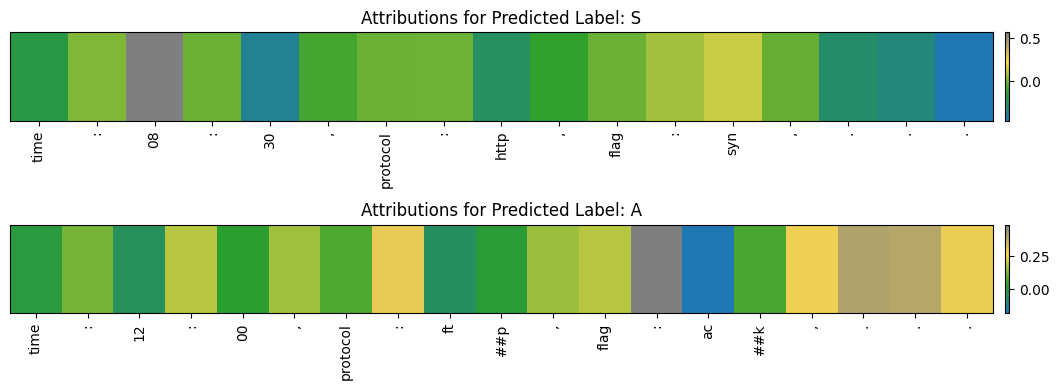

In [3]:
import pandas as pd
import os
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
from torch.utils.data import Dataset
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import wandb
wandb.login(key="a345cb1a827dc39a3eb4703176014176ec31322b")

# Step 1: Load your dataset
# Use the downloaded path for your dataset
file_path = os.path.join(nkongolo_ugransome_dataset_path, 'final(2).csv')

# Step 1: Load your dataset
df = pd.read_csv(file_path)
df.columns = ['Time', 'Protocol', 'Flag', 'Family', 'Clusters', 'SeedAddress',
              'ExpAddress', 'BTC', 'USD', 'Netflow_Bytes', 'IPaddress', 'Threats',
              'Port', 'Prediction']

# Step 2: Convert the dataset into a textual format
def convert_row_to_text(row):
    return (f"Time: {row['Time']}, Protocol: {row['Protocol']}, Flag: {row['Flag']}, "
            f"Family: {row['Family']}, Clusters: {row['Clusters']}, BTC: {row['BTC']}, "
            f"USD: {row['USD']}, Netflow Bytes: {row['Netflow_Bytes']}, Threats: {row['Threats']}, "
            f"Port: {row['Port']}.")

# Create text and labels
df['Text'] = df.apply(convert_row_to_text, axis=1)
texts = df['Text'].tolist()
labels = df['Prediction'].tolist()  # Assuming labels are strings

# Step 3: Convert labels to numerical values
unique_labels = list(set(labels))
label_map = {label: idx for idx, label in enumerate(unique_labels)}
print("Label Map:", label_map)

# Convert labels using the label map
numerical_labels = [label_map[label] for label in labels]

# Step 4: Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, numerical_labels, test_size=0.2, random_state=42
)

# Step 5: Tokenize the data
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Step 6: Create custom dataset
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)

# Step 7: Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(unique_labels))

# Step 8: Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',  # Logs to wandb will be stored here
    logging_steps=10,
    evaluation_strategy="epoch",
    report_to="wandb"  # This will enable logging to wandb
)

# Step 9: Initialize Trainer
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Step 10: Train the model
trainer.train()

# Step 11: Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)

# Create a DataFrame from the results dictionary
evaluation_df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

# Print the table
print("\nEvaluation Results in Table Format:")
print(evaluation_df)

# Save the fine-tuned model
trainer.save_model('fine_tuned_bert')

# Load the fine-tuned model
model = BertForSequenceClassification.from_pretrained('fine_tuned_bert')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Step 12: Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 13: Function to explain model predictions
def explain_prediction(sentence, target_label):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=128, padding='max_length').to(device)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    embeddings = model.bert.embeddings(input_ids)

    def custom_forward(inputs_embeds):
        outputs = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        return outputs.logits

    ig = IntegratedGradients(custom_forward)
    attributions, delta = ig.attribute(embeddings, target=target_label, return_convergence_delta=True)

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    attributions_sum = attributions.sum(dim=-1).squeeze(0)
    attributions_norm = attributions_sum / torch.norm(attributions_sum)

    print("\nToken Attributions:")
    for token, score in zip(tokens, attributions_norm):
        if token not in ['[CLS]', '[SEP]', '[PAD]']:
            print(f"{token}: {score.item():.4f}")

# Example usage
sample_sentence = "Time: 08:30, Protocol: HTTP, Flag: SYN, ..."
target_label = 1  # Adjust as per your label index
explain_prediction(sample_sentence, target_label)

# Step 14: Function to create heatmaps for predictions
def create_stacked_heatmaps(sentences, labels):
    fig, axes = plt.subplots(len(sentences), 1, figsize=(12, 2*len(sentences)))
    if len(sentences) == 1:
        axes = [axes]

    colors = ['#1f77b4', '#2ca02c', '#ffdb4d', '#7f7f7f']
    cmap = LinearSegmentedColormap.from_list('custom', colors)

    for idx, (sentence, label) in enumerate(zip(sentences, labels)):
        # Convert numerical label back to its string representation using the label_map
        label_str = [k for k, v in label_map.items() if v == label][0]

        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=128, padding='max_length').to(device)
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        embeddings = model.bert.embeddings(input_ids)

        def custom_forward(inputs_embeds):
            outputs = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
            return torch.softmax(outputs.logits, dim=-1)

        ig = IntegratedGradients(custom_forward)
        target_label = label  # Use the numerical label for explanation
        attributions, delta = ig.attribute(embeddings, target=target_label, return_convergence_delta=True)

        attributions = attributions.detach().cpu().numpy()[0]
        attributions_sum = attributions.sum(axis=1)
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

        filtered_tokens = [t for t in tokens if t not in ['[CLS]', '[SEP]', '[PAD]']]
        filtered_attributions = [a for t, a in zip(tokens, attributions_sum) if t not in ['[CLS]', '[SEP]', '[PAD]']]

        norm_val = np.linalg.norm(filtered_attributions) + 1e-10
        attributions_norm = np.array(filtered_attributions) / norm_val

        im = axes[idx].imshow([attributions_norm], cmap=cmap, aspect='auto')
        axes[idx].set_yticks([])
        axes[idx].set_xticks(range(len(filtered_tokens)))
        axes[idx].set_xticklabels(filtered_tokens, rotation=90)
        axes[idx].set_title(f"Attributions for Predicted Label: {label_str}")

        plt.colorbar(im, ax=axes[idx], orientation='vertical', pad=0.01)

    plt.tight_layout()
    plt.show()

# Example usage
sentences = [
    "Time: 08:30, Protocol: HTTP, Flag: SYN, ...",
    "Time: 12:00, Protocol: FTP, Flag: ACK, ..."
]
labels = [1, 0]  # Adjust based on your labels
create_stacked_heatmaps(sentences, labels)



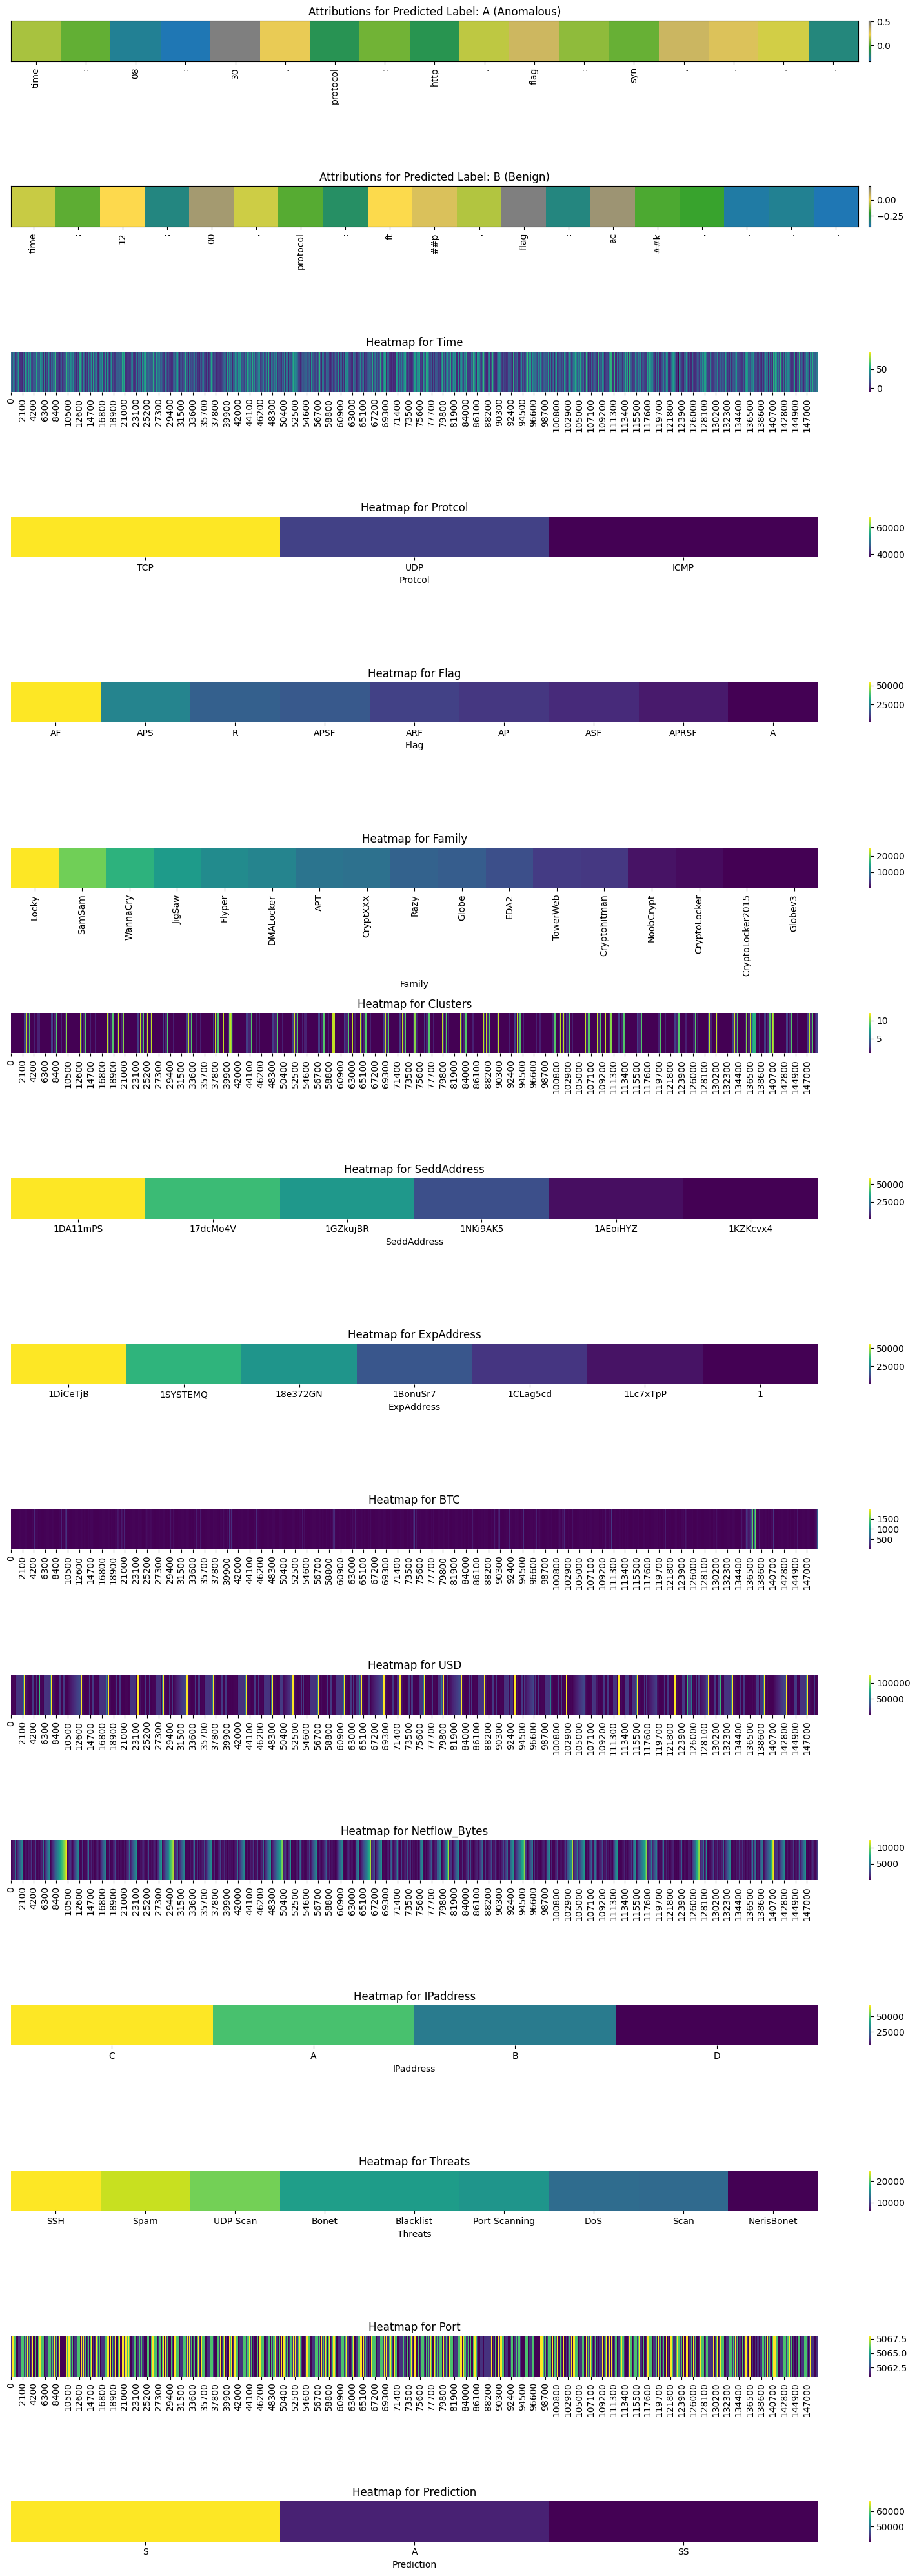

In [4]:
import torch
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients

# Load your dataset
# Use the downloaded path for your dataset
file_path = os.path.join(nkongolo_ugransome_dataset_path, 'final(2).csv')

# Step 1: Load your dataset
df = pd.read_csv(file_path)

# Define the label mapping
unique_labels = ["A (Anomalous)", "B (Benign)"]  # Modify based on your unique labels
label_map = {idx: label for idx, label in enumerate(unique_labels)}

# Example usage sentences
sentences = [
    "Time: 08:30, Protocol: HTTP, Flag: SYN, ...",
    "Time: 12:00, Protocol: FTP, Flag: ACK, ..."
]

# Corresponding labels (using numeric values initially)
numeric_labels = [0, 1]  # Adjust as necessary based on your data

# Function to create heatmaps for attributions and headers
def create_combined_heatmaps(sentences, labels, df):
    # fig, axes = plt.subplots(len(sentences) + len(df.columns), 1, figsize=(12, 2 * (len(sentences) + len(df.columns))))
    fig, axes = plt.subplots(len(sentences) + len(df.columns), 1, figsize=(16, 2.5 * (len(sentences) + len(df.columns))))
    cmap = LinearSegmentedColormap.from_list('custom', ['#1f77b4', '#2ca02c', '#ffdb4d', '#7f7f7f'])

    # Plot attribution heatmaps
    for idx, (sentence, label) in enumerate(zip(sentences, labels)):
        # Tokenize and move to the appropriate device
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=128, padding='max_length').to(device)
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        embeddings = model.bert.embeddings(input_ids)

        # Define a custom forward function for Integrated Gradients
        def custom_forward(inputs_embeds):
            outputs = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
            return torch.softmax(outputs.logits, dim=-1)

        ig = IntegratedGradients(custom_forward)
        attributions, delta = ig.attribute(embeddings, target=label, return_convergence_delta=True)

        attributions = attributions.detach().cpu().numpy()[0]
        attributions_sum = attributions.sum(axis=1)
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

        # Filter out special tokens
        filtered_tokens = [t for t in tokens if t not in ['[CLS]', '[SEP]', '[PAD]']]
        filtered_attributions = [a for t, a in zip(tokens, attributions_sum) if t not in ['[CLS]', '[SEP]', '[PAD]']]

        # Normalize attributions
        norm_val = np.linalg.norm(filtered_attributions) + 1e-10
        attributions_norm = np.array(filtered_attributions) / norm_val

        # Plot the attribution heatmap
        im = axes[idx].imshow([attributions_norm], cmap=cmap, aspect='auto')
        axes[idx].set_yticks([])
        axes[idx].set_xticks(range(len(filtered_tokens)))
        axes[idx].set_xticklabels(filtered_tokens, rotation=90)
        axes[idx].set_title(f"Attributions for Predicted Label: {label_map[label]}")

        # Add colorbar
        plt.colorbar(im, ax=axes[idx], orientation='vertical', pad=0.01)

    # Plot heatmaps for each header in the dataset
    for i, column in enumerate(df.columns):
        if df[column].dtype in ['int64', 'float64']:  # For numerical columns
            sns.heatmap(df[[column]].T, ax=axes[len(sentences) + i], cmap='viridis', cbar=True)
        else:  # For categorical columns, count unique values and plot
            value_counts = df[column].value_counts().to_frame().T
            sns.heatmap(value_counts, ax=axes[len(sentences) + i], cmap='viridis', cbar=True)

        axes[len(sentences) + i].set_title(f"Heatmap for {column}")
        axes[len(sentences) + i].set_yticks([])  # Hide y-ticks for cleaner look

    plt.tight_layout()
    plt.show()

# Call the function
create_combined_heatmaps(sentences, numeric_labels, df)


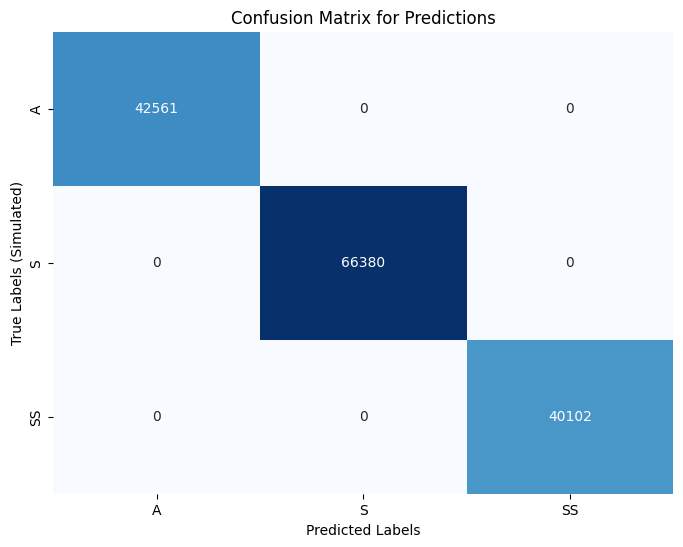

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load your dataset
# Use the downloaded path for your dataset
file_path = os.path.join(nkongolo_ugransome_dataset_path, 'final(2).csv')

# Step 1: Load your dataset
df = pd.read_csv(file_path)

# Extract the predicted labels from the 'Prediction' column
predicted_labels = df['Prediction']

# Use unique labels from the 'Prediction' column as categories
categories = sorted(predicted_labels.unique())

# Since we're only working with the 'Prediction' column, we'll simulate true labels for demonstration
# In a real scenario, you should have a corresponding true label to compare against.
true_labels = predicted_labels  # This will make the confusion matrix a perfect diagonal

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels (Simulated)')
plt.title('Confusion Matrix for Predictions')
plt.show()


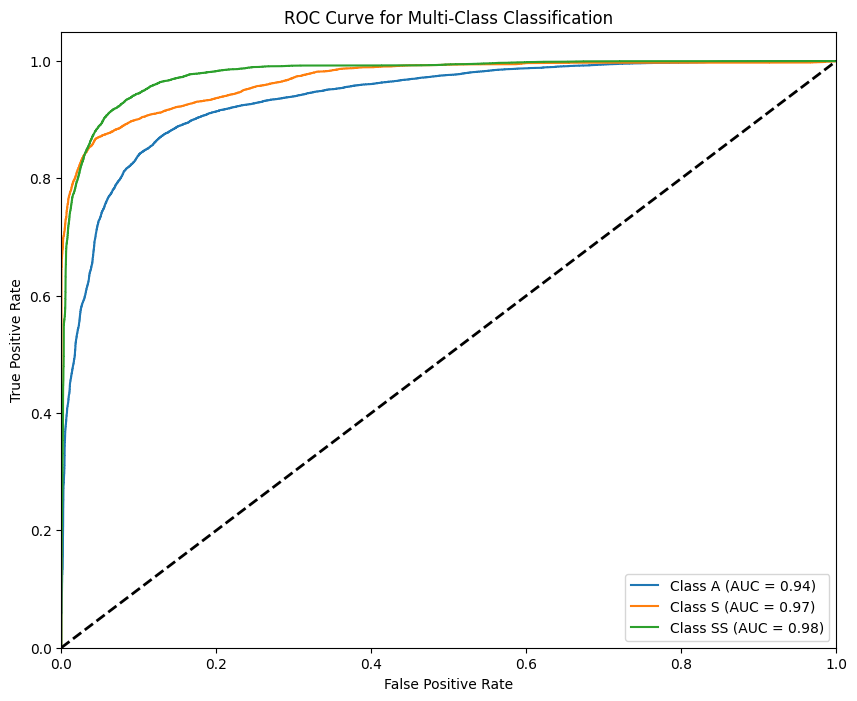

In [6]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Load your dataset
# Use the downloaded path for your dataset
file_path = os.path.join(nkongolo_ugransome_dataset_path, 'final(2).csv')

# Step 1: Load your dataset
df = pd.read_csv(file_path)

# Extract the features and the target label
X = df.drop('Prediction', axis=1)  # Use all columns except 'Prediction' as features
y = df['Prediction']  # Target labels

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# One-hot encode categorical features
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'  # Leave numerical columns as they are
)

# Transform the features
X_transformed = column_transformer.fit_transform(X)

# Encode the labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_encoded, test_size=0.3, random_state=42)

# Binarize the labels for the test set only
y_test_binarized = label_binarize(y_test, classes=np.unique(y_encoded))
n_classes = y_test_binarized.shape[1]

# Train a Logistic Regression model using OneVsRestClassifier
model = OneVsRestClassifier(LogisticRegression(max_iter=10000))
model.fit(X_train, y_train)

# Get the probability scores for the test set
y_score = model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


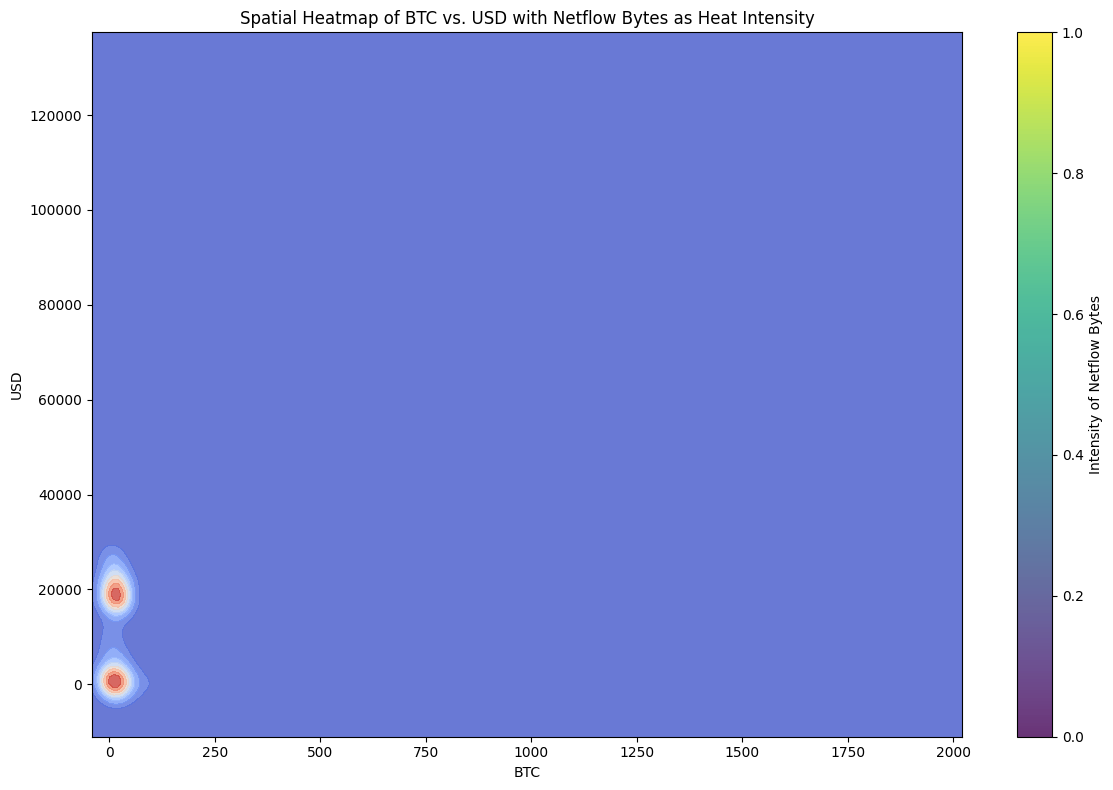

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
# Use the downloaded path for your dataset
file_path = os.path.join(nkongolo_ugransome_dataset_path, 'final(2).csv')

# Step 1: Load your dataset
df = pd.read_csv(file_path)

# Extract numerical columns for plotting
x_data = df['BTC'].values 
y_data = df['USD'].values  
heat_data = df['Netflow_Bytes'].values  

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the KDE
kde = sns.kdeplot(
    x=x_data, y=y_data, weights=heat_data, 
    cmap='coolwarm', fill=True, thresh=0, alpha=0.8, ax=ax
)

# Add colorbar using the image object from kdeplot
mappable = kde.get_children()[0]  # Get the mappable object
fig.colorbar(mappable, ax=ax, label='Intensity of Netflow Bytes')

# Customize the plot
ax.set_title('Spatial Heatmap of BTC vs. USD with Netflow Bytes as Heat Intensity')
ax.set_xlabel('BTC')
ax.set_ylabel('USD')

# Show the plot
plt.tight_layout()
plt.show()

